In [3]:
import pandas as pd
import numpy as np
# import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import seaborn as sns
import random
import os
import gc
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models, Sequential
from tensorflow.keras import optimizers

from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, SeparableConv2D

from tensorflow.keras.applications.vgg16 import VGG16

from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array, load_img

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve

from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

/opt/homebrew/Caskroom/miniconda/base/envs/TF/lib/python3.8/site-packages/requests/__init__.py:109: RequestsDependencyWarning: urllib3 (1.26.16) or chardet (3.0.0)/charset_normalizer (3.1.0) doesn't match a supported version!
  warnings.warn(


ImportError: cannot import name 'img_to_array' from 'keras.preprocessing.image' (/opt/homebrew/Caskroom/miniconda/base/envs/TF/lib/python3.8/site-packages/keras/preprocessing/image.py)

In [8]:
test_dir = "dataset/test/"
train_dir = "dataset/train"
val_dir = "dataset/valid"

batch_size=64
target_size=(150,150)

train_dataGenerator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                               horizontal_flip=True,
                                                               validation_split=0.2)
train_ds = train_dataGenerator.flow_from_directory(train_dir,
                                                        batch_size=batch_size,
                                                        target_size=target_size, 
                                                        shuffle=True,
                                                        class_mode='binary')
validation_ds = train_dataGenerator.flow_from_directory(val_dir,
                                                        batch_size=batch_size,
                                                        target_size=target_size,
                                                        shuffle=True,
                                                        class_mode='binary')

test_dataGenerator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                              horizontal_flip=True)
test_ds = test_dataGenerator.flow_from_directory(test_dir,
                                                  batch_size=batch_size,
                                                  target_size=target_size,
                                                  shuffle=True,
                                                  class_mode="binary")

Found 2536 images belonging to 2 classes.
Found 100 images belonging to 2 classes.
Found 300 images belonging to 2 classes.


In [9]:
base_model = VGG16(include_top=False,weights='imagenet',input_shape=(150,150,3))
for layer in base_model.layers:
   layer.trainable = False

2024-04-10 20:48:10.144657: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Max
2024-04-10 20:48:10.144692: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 64.00 GB
2024-04-10 20:48:10.144704: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 24.00 GB
2024-04-10 20:48:10.144743: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-04-10 20:48:10.144769: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [40]:
model = keras.models.Sequential()
model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dense(512, activation = 'relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation = 'sigmoid'))

In [33]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 conv2d_2 (Conv2D)           (None, 2, 2, 32)          147488    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 1, 1, 32)          0         
 g2D)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 32)                0         
                                                                 
 dense_8 (Dense)             (None, 512)               16896     
                                                                 
 dropout_4 (Dropout)         (None, 512)               0         
                                                      

In [29]:
early_stopping = EarlyStopping(
    monitor='val_loss',    
    min_delta=0.001,      
    patience=8,            
    verbose=1,
    restore_best_weights=True
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',  #val_loss no overfitting   
    min_delta=0.001,  
    mode="min",
    factor=0.5,                 
    patience=6,                 
    min_lr=1e-7,                
    verbose=1                   
)

In [41]:
model.compile(loss = 'binary_crossentropy', optimizer = keras.optimizers.Adam(), metrics = ['acc'])
history = model.fit(train_ds, epochs=50, validation_data = validation_ds, callbacks=[early_stopping, lr_scheduler])

Epoch 1/50


2024-04-10 21:09:35.663317: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


40/40 [==============================] - ETA: 0s - loss: 2.7097 - acc: 0.6195

2024-04-10 21:09:39.751271: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


40/40 [==============================] - 5s 106ms/step - loss: 2.7097 - acc: 0.6195 - val_loss: 1.1669 - val_acc: 0.7200 - lr: 0.0010
Epoch 2/50
40/40 [==============================] - 4s 99ms/step - loss: 1.6022 - acc: 0.6940 - val_loss: 1.1243 - val_acc: 0.7300 - lr: 0.0010
Epoch 3/50
40/40 [==============================] - 4s 99ms/step - loss: 0.9653 - acc: 0.7232 - val_loss: 0.9572 - val_acc: 0.6600 - lr: 0.0010
Epoch 4/50
40/40 [==============================] - 4s 98ms/step - loss: 0.6353 - acc: 0.7579 - val_loss: 0.7883 - val_acc: 0.6600 - lr: 0.0010
Epoch 5/50
40/40 [==============================] - 4s 98ms/step - loss: 0.5068 - acc: 0.7780 - val_loss: 0.5832 - val_acc: 0.7400 - lr: 0.0010
Epoch 6/50
40/40 [==============================] - 4s 97ms/step - loss: 0.5143 - acc: 0.7741 - val_loss: 0.9969 - val_acc: 0.6100 - lr: 0.0010
Epoch 7/50
40/40 [==============================] - 4s 98ms/step - loss: 0.4961 - acc: 0.7764 - val_loss: 0.9281 - val_acc: 0.6200 - lr: 0.0010
Ep

<Axes: >

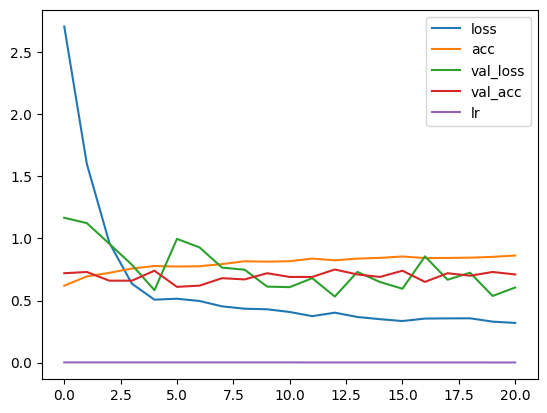

In [42]:
pd.DataFrame(history.history).plot()

In [44]:
model.evaluate(test_ds)

5/5 [==============================] - 1s 107ms/step - loss: 0.4023 - acc: 0.8300


[0.40225499868392944, 0.8299999833106995]

In [45]:
model.save("early_detection.h5")

/Users/gunachowdary/miniconda/envs/course_repo/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [1]:
import pandas as pd
import numpy as np
# import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import seaborn as sns
import random
import os
import gc
import tensorflow as tf

In [3]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_4 (Flatten)         (None, 8192)              0         
                                                                 
 dense_12 (Dense)            (None, 512)               4194816   
                                                                 
 dropout_6 (Dropout)         (None, 512)               0         
                                                                 
 dense_13 (Dense)            (None, 1)                 513       
                                                                 
Total params: 18910017 (72.14 MB)
Trainable params: 4195329 (16.00 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [ ]:
tf.__version__

'2.9.0'

In [3]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Our function needs a different name to sklearn's plot_confusion_matrix
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False): 
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).
  
  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """  
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")

In [4]:
from tensorflow.keras.models import load_model

# Load the model
model = load_model('early_detection.h5')
test_dir = "test/"
batch_size=64
target_size=(150,150)

test_dataGenerator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                              horizontal_flip=True)
test_ds = test_dataGenerator.flow_from_directory(test_dir,
                                                  batch_size=batch_size,
                                                  target_size=target_size,
                                                  shuffle=True,
                                                  class_mode="binary")
                                                  

model.evaluate(test_ds)

2024-04-11 01:23:15.241479: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-04-11 01:23:15.241505: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-04-11 01:23:15.241510: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-04-11 01:23:15.241724: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-04-11 01:23:15.241746: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Found 300 images belonging to 2 classes.


2024-04-11 01:23:16.230688: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


5/5 [==============================] - 4s 840ms/step - loss: 0.3892 - acc: 0.8200


[0.3892355263233185, 0.8199999928474426]

1/5 [=====>........................] - ETA: 1s

2024-04-11 01:23:34.387458: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


5/5 [==============================] - 3s 784ms/step


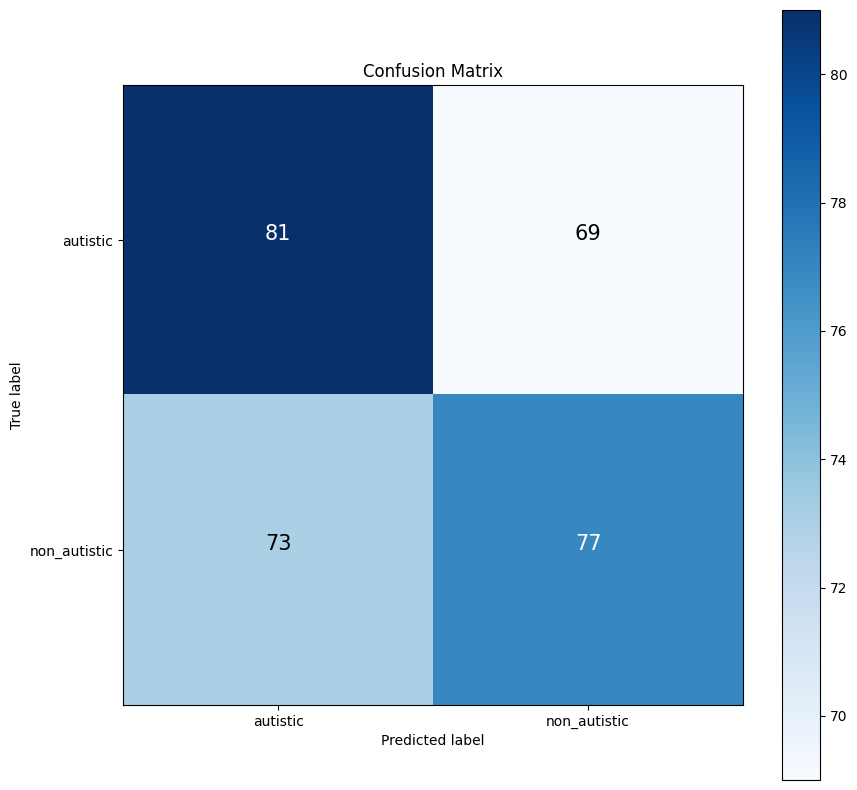

In [5]:
# Get the true labels
y_true = test_ds.classes

# Make sure all the data in the test set is used exactly once
test_steps = np.ceil(test_ds.samples / test_ds.batch_size)

# Get the predicted labels
y_pred = model.predict(test_ds, steps=test_steps)

# Since the predictions are in the form of probabilities, convert them to class labels
y_pred = np.where(y_pred > 0.5, 1, 0)


# Get the class names from the class_indices attribute of the DirectoryIterator object
class_names = list(test_ds.class_indices.keys())

make_confusion_matrix(y_true=y_true,
                      y_pred=y_pred,
                      classes=class_names,
                      figsize=(10, 10),
                      text_size=15)

In [6]:
from sklearn.metrics import accuracy_score, precision_score, f1_score

# Assuming y_true and y_pred are your true and predicted labels
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'F1 Score: {f1}')

Accuracy: 0.5266666666666666
Precision: 0.5273972602739726
F1 Score: 0.5202702702702703


In [7]:
precision = precision_score(y_true, y_pred, average='micro')
f1 = f1_score(y_true, y_pred, average='micro')

In [8]:
precision, f1

(0.5266666666666666, 0.5266666666666666)